In [1]:
%matplotlib inline

import os
import datetime
import pytz
import time
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import mean_squared_error,r2_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

from scipy.sparse import csr_matrix, hstack

In [2]:
## daily prices

def preprbd(x_db):
    x_db.columns = [x.lower() for x in x_db.columns.values]
    ## x_db.drop(['date_text','month','month day','day','year'],axis=1,inplace=True)
    x_db.drop(['open','high','low','market cap'],axis=1,inplace=True)


bit_price_d = pd.read_csv("bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv")
bit_price_d.columns = [x.lower() for x in bit_price_d.columns.values]


bit_price_d = bit_price_d[['timestamp','close']]
bit_price_d.rename(columns={'close':'btc_close'},inplace=True)

bit_price_d['date_msc'] = bit_price_d['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
#bit_price_d.head()

##preprbd(bit_price_d)
##bit_price_d.rename(columns={'close':'btc_close'},inplace=True)


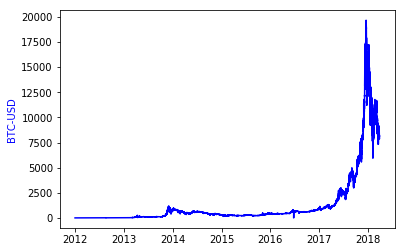

In [3]:
fig, ax1 = plt.subplots()

ax1.plot(bit_price_d['date_msc'],bit_price_d['btc_close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


plt.show()

#### Reading news

In [4]:
re.sub("([0-9]*),([0-9]*)","\\1\\2","ninth in terms of BTC/USD ($1,536,570) trading")

'ninth in terms of BTC/USD ($1536570) trading'

In [12]:
%%time

def clean_text(text):
    text = re.sub("<.*?>.*?</.*?>","",text)
    text = re.sub("&amp;","&",text)
    text = re.sub("\n"," ",text)
    text = re.sub("'","",text)
    text = re.sub("\$([0-9])","USD \\1",text)
    text = re.sub("([0-9])k","\\1 thousands",text)    
    text = re.sub("([0-9])m","\\1 million",text)
    text = re.sub("([0-9])bn","\\1 billion",text)
    text = re.sub("([0-9]*),([0-9]*)","\\1\\2",text)  ## removing thousands separator
    text = re.sub("R&D","RnD",text)

    return text
    

## Loading text
DIR_FILE = "news_bloomberg"
news_corpus = []
for i_file in os.listdir(DIR_FILE):
    
    # read file
    tt = open (DIR_FILE + "/"+i_file, encoding='utf-8', errors='ignore')


    # process headline
    news_headline = tt.readline()
    news_headline = re.sub("\n","",news_headline)
    news_headline = clean_text(news_headline)
    
    # now time for time
    news_time_str = tt.readline()
    news_time = datetime.datetime.strptime(news_time_str[0:16],"%Y-%m-%dT%H:%M")
    news_time = news_time.replace(tzinfo=pytz.UTC)
    news_timestamp = news_time.timestamp()

    # news text and brief
    news_text = "".join(tt.readlines())
    rm = re.search("<content>(.*?)</content>",news_text)
    content = rm.group(0) 
    
    news_text = clean_text(news_text)
    news_corpus.append([news_time, news_timestamp, content,news_headline,news_text])
    
    
print ("text loaded")

news_corpus = pd.DataFrame(news_corpus)
news_corpus.columns = ['date_full_orig','timestamp_orig','content','headline','text']


## aggregate text and headlines on daily level
def compute_metrics(x):
    result = {'headline': " ".join(x['headline']), 
              'text': " ".join(x['text']),'count_news':len(x)}
    return pd.Series(result, name='metrics')

news_corpus = news_corpus.groupby(['date_full_orig','timestamp_orig']).apply(compute_metrics)



news_corpus.sort_index(inplace=True)
news_corpus.reset_index(inplace=True)

news_corpus['date_orig'] = news_corpus['date_full_orig'].apply(lambda x: x.date())
news_corpus['date_str'] = news_corpus['date_orig'].apply(str)

### prefiltering
###
news_corpus = news_corpus.query('date_str>="2017-11-01"')
news_corpus.reset_index(inplace=True)
news_corpus.drop('index',axis=1,inplace=True)


print ("metrics computed")

news_corpus.head()

text loaded
metrics computed
Wall time: 2.36 s


In [14]:
news_corpus[['date_full_orig','date_orig','date_str','timestamp_orig']].head()

metrics,date_full_orig,date_orig,date_str,timestamp_orig
0,2017-11-01 07:38:00+00:00,2017-11-01,2017-11-01,1.509522e+09
1,2017-11-01 11:19:00+00:00,2017-11-01,2017-11-01,1.509535e+09
2,2017-11-01 15:45:00+00:00,2017-11-01,2017-11-01,1.509551e+09
3,2017-11-01 16:00:00+00:00,2017-11-01,2017-11-01,1.509552e+09
4,2017-11-01 17:39:00+00:00,2017-11-01,2017-11-01,1.509558e+09


In [15]:
pd.set_option('display.max_colwidth', -1)
aa = news_corpus.sample(1)
print (aa['text'])
pd.set_option('display.max_colwidth', 50)

502      
Name: text, dtype: object


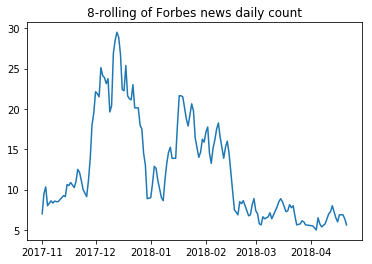

In [16]:
## Plot news count

fig, axs = plt.subplots()

bb_daily = news_corpus.groupby('date_orig')[['count_news']].sum()
bb_daily.reset_index(inplace=True)
bb_daily['date_str']= bb_daily['date_orig'].apply(str)
##bb_daily = bb_daily.query("date_str>='2017-10-01'")
aa = bb_daily.rolling(8,min_periods=1)['count_news'].mean()
axs.plot(bb_daily['date_orig'],aa)
axs.title.set_text("8-rolling of Forbes news daily count")



#### Explanation model

In [17]:
#pd.set_option('display.max_colwidth', 50)
news_corpus.head()

metrics,date_full_orig,timestamp_orig,count_news,headline,text,date_orig,date_str
0,2017-11-01 07:38:00+00:00,1.509522e+09,1,If Goldman Sachs Wont Trade Bitcoin Someone El...,Wall Street was never supposed to get Bitcoi...,2017-11-01,2017-11-01
1,2017-11-01 11:19:00+00:00,1.509535e+09,1,Bitcoin Surges Even More After CME Futures Ann...,Bitcoin extended gains to a new record on We...,2017-11-01,2017-11-01
2,2017-11-01 15:45:00+00:00,1.509551e+09,1,Bitcoin Is in Uncharted Territory Says Gadflys...,,2017-11-01,2017-11-01
3,2017-11-01 16:00:00+00:00,1.509552e+09,1,CMEs Bitcoin Foray Has Three Plausible Outcomes,CME Group announced plans to offer a bitcoin...,2017-11-01,2017-11-01
4,2017-11-01 17:39:00+00:00,1.509558e+09,1,Cryptocurrency Promoter Charged With Securitie...,A businessman accused of fraud involving two...,2017-11-01,2017-11-01


In [58]:
%%time

##  Get daily spot price
##

all_data = bit_price_d[['timestamp','btc_close']].copy(deep=True)

## filter with respect to news
rows_filt = (bit_price_d['timestamp'] >=min(news_corpus['timestamp_orig'])-3600) & (bit_price_d['timestamp'] <=max(news_corpus['timestamp_orig'])+3600)
bit_price_d = bit_price_d.loc[rows_filt,:].copy(deep=True)

all_data.sort_values('timestamp',ascending=True,inplace=True)
all_data.reset_index(inplace=True)
all_data.drop('index',axis=1,inplace=True)


## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)
all_data['btc_return'] = np.log(price) - np.log(price_l1)
all_data['btc_dir'] = (all_data['btc_return']>0) * 1 
all_data.dropna(inplace=True)


news_corpus['timestamp'] = news_corpus['timestamp_orig']+60

all_data = all_data.merge(news_corpus[['timestamp','count_news','headline','text']],how='left',on='timestamp')
all_data.fillna('',inplace=True)

filt = [x=='' for x in all_data['count_news']]
all_data.loc[filt,'count_news']=0

## filtering nulls
all_data = all_data.query('count_news>0')
all_data.reset_index(inplace=True)


class LemmaTokenizer():
     def __init__(self):
        self.stm = SnowballStemmer('english')
        self.tkn = RegexpTokenizer(r'\w+')
     def __call__(self, doc):
         return [self.stm.stem(t) for t in self.tkn.tokenize(doc)]
         ##return [self.stm.stem(t) for t in word_tokenize(doc)]

## make headlines
##
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=5, tokenizer=LemmaTokenizer(),
                       stop_words='english')
tfidif_headline = tfidf.fit_transform(all_data['headline'])
tfidf_col_names = tfidf.get_feature_names() 
print (tfidif_headline.shape)
print ("headline processed")

tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=10, tokenizer=LemmaTokenizer(),
                       stop_words='english')
tfidif_text = tfidf.fit_transform(all_data['text'])
tfidf_col_names += tfidf.get_feature_names()
print (tfidif_text.shape)
print ("text processed")


## add column with news counts
tfidif_vectors = hstack([csr_matrix(all_data[['count_news']].astype(float)),tfidif_headline,tfidif_text],format='csr')
tfidf_col_names = ['#var_count_news'] + tfidf_col_names

##tfidif_vectors = hstack([tfidif_headline,tfidif_text],format='csr')
## tfidif_vectors = tfidif_headline


print (tfidif_vectors.shape)
## tfidif_vectors
all_data

(1710, 549)
headline processed
(1710, 6575)
text processed
(1710, 7125)
Wall time: 10.9 s


In [59]:
## split into test and train
##

train_size =0.95
train_ind = int(all_data.shape[0] * train_size)
print (all_data.loc[train_ind,'timestamp'])


matr = tfidif_vectors

## dates_train =all_data.loc[:train_ind,'date']
X_train = matr[:train_ind+1,]
y_train = all_data.loc[:train_ind,'btc_dir']

## dates_test = all_data.loc[train_ind+1:,'date']
X_test = matr[train_ind+1:,]
y_test =  all_data.loc[train_ind+1:,'btc_dir']

1520884860


#### Ridge Model

In [60]:
def model_predict (mm,titles=[""]):
    
    print ("Fitting the model")
    ##mm.fit(X_train,y_train)
    
    y_pred = mm.predict(X_test)    

    ## Plot train data
    try: 
        y_score = mm.decision_function(X_test)
    except:
        y_score = mm.predict_proba(X_test)
        y_score = [x[1] for x in y_score]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)    
    print ("ROC-AUC test: ", roc_auc) 
    
    
    fig, (axs) = plt.subplots(1,1, figsize=(5,5))
    axs.plot(fpr,tpr,'b', label="ROC_AUC: {0:.02f}".format(roc_auc))
    axs.plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs.set_title(titles[0])
    axs.legend()
    plt.show()

In [81]:

def model_kfold_predict (mm, folds_num = 4, titles = ["",""]):
    roc_auc = []
    
    fig, (axs1, axs2) = plt.subplots(1,2, figsize=(15,7))
    axs1.plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs2.plot([0, 1], [0, 1], color='navy', linestyle='--')

    kf = KFold (n_splits=folds_num,shuffle=False)
    ## tscv = TimeSeriesSplit(n_splits=folds_num)
    print ("Doing TimeSeries validation")    
        
    i = 0 
    for train_index, test_index in kf.split(X_train):
        i=i+1
        print ("Doing fold " + str(i))
        
        X_fold_train, X__fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y__fold_test = y_train[train_index], y_train[test_index]

        mm.fit(X_fold_train, y_fold_train)
        
        try: 
            y_score = mm.decision_function(X__fold_test)
        except:
            y_score = mm.predict_proba(X__fold_test)
            y_score = [x[1] for x in y_score]
        
        fpr, tpr, _ = roc_curve(y__fold_test, y_score)
        a1 = auc(fpr, tpr)
        roc_auc.append(a1)
        axs1.plot(fpr,tpr, label="fold "+str(i)+" AUC = {0:.02f}".format(a1))
        
    print ("KFold ROC_AUC: ",["{0:.4f}".format(x) for x in roc_auc], np.mean(roc_auc))
    
    
    ## Do on test data
    mm.fit(X_train,y_train)
    ## Plot train data
    try: 
        y_score = mm.decision_function(X_test)
    except:
        y_score = mm.predict_proba(X_test)
        y_score = [x[1] for x in y_score]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)    
    print ("ROC-AUC test: ", roc_auc) 

    axs2.plot(fpr,tpr,label="ROC_AUC: {0:.02f}".format(roc_auc))
    
    axs1.set_title (titles[0])
    axs2.set_title (titles[1])
    axs1.legend(loc=4)
    axs2.legend(loc=4)
    plt.show()

Doing TimeSeries validation
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 5
Doing fold 6
Doing fold 7
Doing fold 8
Doing fold 9
Doing fold 10
KFold ROC_AUC:  ['0.5187', '0.5048', '0.4812', '0.6025', '0.5488', '0.5172', '0.5239', '0.4989', '0.5138', '0.4716'] 0.518143620228
ROC-AUC test:  0.583896396396


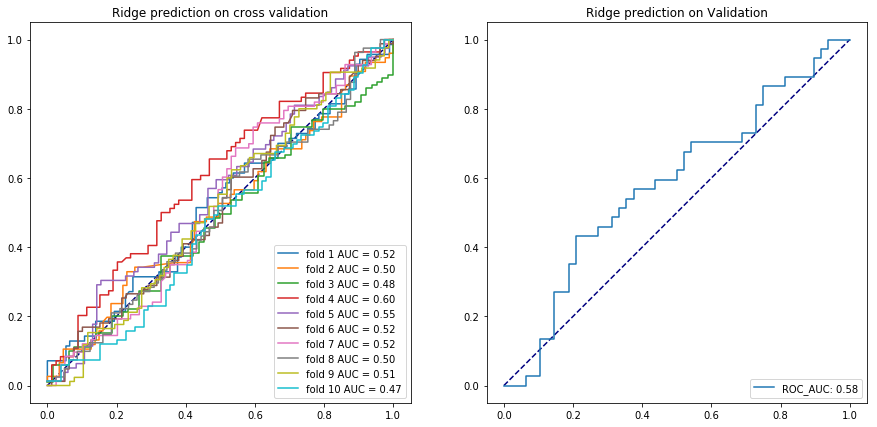

In [91]:
rdg = RidgeClassifier(alpha=0.15, fit_intercept=True, normalize=False)
model_kfold_predict(rdg,folds_num=10, titles=["Ridge prediction on cross validation","Ridge prediction on Validation"])

#### Extra Trees

In [76]:
%%time
kf = KFold (n_splits=4)
tscv = TimeSeriesSplit(n_splits=10)

for i_tree in np.arange(10,500,10):
    etr = ExtraTreesClassifier(n_estimators=i_tree, criterion='gini', 
                               max_depth=None, min_samples_split=2, 
                               min_samples_leaf=5, n_jobs = -1, random_state=14)

    scores = cross_val_score(etr, X_train,y_train,cv=kf,scoring ='roc_auc')
    print (i_tree, np.mean(scores), scores)

10 0.4945087673 [ 0.45921059  0.47645157  0.52820868  0.51416424]
20 0.507319422193 [ 0.47035477  0.49107664  0.52870633  0.53913994]
30 0.514434872403 [ 0.49128793  0.50251653  0.52831792  0.5356171 ]
40 0.515983950192 [ 0.49117903  0.4995745   0.53993397  0.5332483 ]
50 0.518497006989 [ 0.48139006  0.50883826  0.54395164  0.53980807]
60 0.521577468939 [ 0.49340545  0.51011476  0.54174253  0.54104713]
70 0.52463379976 [ 0.4997459   0.51903812  0.54368461  0.53606657]
80 0.524497528747 [ 0.49814869  0.52540848  0.54060156  0.53383139]
90 0.523534867286 [ 0.49778568  0.52426571  0.54105066  0.53103741]
100 0.524014751877 [ 0.49503896  0.52601634  0.54083218  0.53417153]
110 0.526523731355 [ 0.49386525  0.52855719  0.54668269  0.5369898 ]
120 0.524183725188 [ 0.49584967  0.52393746  0.54029811  0.53664966]
130 0.52884902607 [ 0.50133101  0.52991879  0.54660986  0.53753644]
140 0.528331779862 [ 0.49892309  0.53016193  0.54834559  0.5358965 ]
150 0.528158485926 [ 0.49681768  0.53393066  0.

KeyboardInterrupt: 

In [78]:
%%time
etr  = ExtraTreesClassifier(n_estimators=160, criterion='gini', 
                           max_depth=None, min_samples_split=2, 
                           min_samples_leaf=5, n_jobs = -1, 
                           random_state=14, bootstrap = True, 
                           oob_score  = False)
etr.fit(X_train,y_train)

Wall time: 292 ms


Doing TimeSeries validation
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 5
Doing fold 6
Doing fold 7
Doing fold 8
Doing fold 9
Doing fold 10
KFold ROC_AUC:  ['0.6070', '0.4226', '0.5429', '0.5108', '0.5824', '0.5348', '0.5279', '0.5360', '0.5212', '0.5095'] 0.529495527682
ROC-AUC test:  0.546452702703


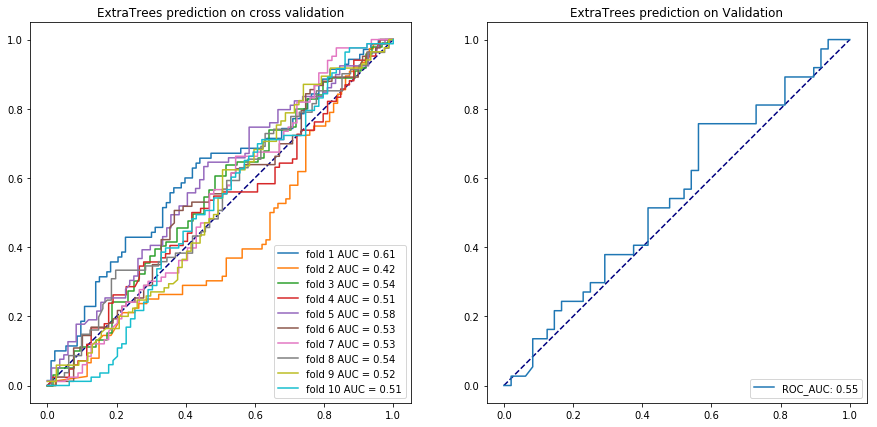

In [92]:
## model_kfold_predict(etr)
model_kfold_predict(etr,folds_num=10, titles=["ExtraTrees prediction on cross validation","ExtraTrees prediction on Validation"])

In [ ]:
imp = etr.feature_importances_
ind = np.argsort(imp)
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, imp[i_ind])


In [ ]:
## Plot  data
fig, (axs,axs2) = plt.subplots(1,2, figsize=(15,5))

##fig2, (axs2) = plt.subplots()
y_pred = rdg.predict(X_test)
print ("Ridge MSE {0:.5f}".format(mean_squared_error(y_pred,y_test)))
axs.plot(dates_test,y_test,'b')
axs.plot(dates_test,y_pred,'r')
axs.set_title("Bitcoin prediction using Ridge")

axs.legend( ['BTC return', 'Model'])

y_pred = etr.predict(X_test)
print ("ExtraTrees MSE {0:.5f}".format(mean_squared_error(y_pred,y_test)))
axs2.plot(dates_test,y_test,'b')
axs2.plot(dates_test,y_pred,'r')
axs2.set_title("Bitcoin prediction using Extratrees")
axs2.legend( ['BTC return', 'Model'])
fig.autofmt_xdate()
plt.show()